# **Comparison of CuPy vs TensorFlow Cholesky decomposition**

## Backstory
About a month ago, I came across a NumPy framework for neural networks, written by Scott Biggs. The [LinkedIn post](https://www.linkedin.com/posts/scott-biggs-112970255_neuralnetworks-deeplearning-numpy-activity-7332591624713060352-VmnW?utm_source=share&utm_medium=member_desktop&rcm=ACoAAELL8XMBJTK1p-WfNsDJT3yVbd5tYDcor8o) and [Github repo](https://github.com/ScottBiggs2/Generative-AI-Projects/tree/main/AI%20in%20Numpy) are available here. He said that:

> This project helped me deeply understand what’s happening under the hood of modern deep learning libraries. Building every piece myself — from weight initialization to optimizer updates — gave me a clearer picture of how neural nets really learn.

As a numerics enthusiast, I imagined this resulted in a fair speedup in certain computation areas. One of my professors at KU Leuven described NumPy as "Matlab in your Python". That is probably the most accurate description. You get a lot of functionalities, efficiency and online support. The relevance of this finding will be clear soon enough, trust me...

Fast forward to some days ago, I was looking through the literature for my university seminar about electrical signal integrity. In it, I found out about Gaussian Process Regression (GPR) [[1]](#ref1). It is a key model in probabilistic supervised machine learning, widely
applied in regression and classification tasks.
It makes predictions incorporating prior knowledge
(kernels) and provides uncertainty measures over its
predictions. For two datapoints $\mathbf{x}_i,\mathbf{x}_j$, the kernel $k(\mathbf{x}_i,\mathbf{x}_j)$ is a function that maps it to a space that tells us how similar two points are. The most famouse kernel is the Radial Basis Function (RBF):
$$
k(\mathbf{x}_i,\mathbf{x}_j)=\exp(-\frac{|| \mathbf{x}_i-\mathbf{x}_j||^2}{2\sigma_k^2}),
$$
which makes use of the distance between the points to indicate similarity. It has a hyperparameter $\sigma_k^2$ which determines the "width of importance". A smaller value gives $k(\mathbf{x}_i,\mathbf{x}_j) \approx 0$, meaning points have to be closer to be considered relevant to one another. On the other hand, $\sigma_k^2 \rightarrow \infty$ outputs 1 for all point pairs. The trick is to fine tune this parameter during training. Elements $k(\mathbf{x}_i,\mathbf{x}_j)$ form the kernel matrix $K$. The algorithm uses this covariance matrix to estimate values at other points based on the similarity with known points. An overview of kernel uses in machine learning (aka "kernel methods"), is given in the [article](https://medium.com/@qjbqvwzmg/kernel-methods-in-machine-learning-theory-and-practice-b030bbe0eacc).

The "naive" algorithm (also used by [scikit-learn](https://scikit-learn.org/stable/index.html)) version is given in [[1]](#ref1). Beside it, there are adaptations, including sparse kernel approximations or conjugate gradient usage [[2]](#ref2). Some of these methods found their way into Python code, two of which are [GPFlow](https://github.com/GPflow/GPflow) [[3]](#ref3) and [GPyTorch](https://github.com/cornellius-gp/gpytorch) [[4]](#ref4). They are TensorFlow and PyTorch implementations of the GPR algorithm, both aimed at GPU-based acceleration.

The most expensive step in the "vanilla" algorithm is the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition). It is a method of decomposing our shifted symmetric, positive definite kernel matrix $K+\sigma_n^2I$ into

$$
K+\sigma_n^2I=LL^T,
$$

where $L$ is a lower triangular matrix. A small shift value $\sigma_n^2$ is chosen by the user, with typical value being orders of magnitude smaller than $\sigma_k$. For an $n \times n$ matrix $K+\sigma_n^2I$ (meaning there are $n$ datapoints), the time complexity of the Cholesky matrix decomposition is $\mathcal{O}(\frac{n^3}{6})$ in general. GPyTorch avoids dealing with this method by employing some advanced techniques, while GPFlow sticks with it.

Now we get back to the "Matlab inside Python" part. I was curious to see if the NumPy implementation of this algorithm would beat the sophisticated deep learning frameworks of TensorFlow and PyTorch. If it would this "vanilla" algo test, we might get onto more interesting "chocolate" or "stracciatella" versions (excuse my bad puns, I will try to restrain myself from now on). I decided to test it againts TensorFlow's implementation first. If it were successful, advanced techniques could be implemented and benchmarked against Pytorch as a golden standard for deep learning research. "Great", I thought to myself, "let's see how TensorFlow compares!"

##CuPy
However, we are not playing fair. Both TensorFlow and PyTorch benefit from GPU optimization, while NumPy is written for CPU. Fortunately, there exists a CUDA-enabled version of the module, called [CuPy](https://github.com/cupy/cupy/tree/main) [[5]](#ref5). Also, because both GPFlow and CuPy libraries were released in the same year, we are comparing apples to apples, speaking in the terms of technology development.

In [10]:
#Connected to the A100 Colab hardware accelerator to utilize GPU capablities.
#Check for CUDA version with command:
#!nvcc --version
#Replace 12x with the version Colab is using
#!pip install cupy-cuda12x
import cupy as cp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(42)

One bottleneck I encountered while writing the code was using scikit-learn's Kernel class to compute the RBF kernel. It was written for NumPy, and was *painufully* slow in the computation of the kernel matrix $K$ from the data matrix $X$. This was made worse by the fact that, at one point, conversion between CuPy and NumPy arrays had to be executed.

To get around that, custom kernel class had to be written in order to accept CuPy's `cupy.array` as an input. This resulted in 10X time reduction. I also wrote the same kernel for TensorFlow's `tf.Tensor` class. I found almost identical code in the GPFlow repository. This allowed to compare frameworks without the need for any other module being included in the process. Many OOP and "idiot-proof" features are missing, which need to be implemented for production-level code. This "bare metal" implementation only serves the purpose of speed comparison.



In [11]:
class RBFcp:

    def __init__(self, length_scale=1.0):
        self.length_scale = length_scale

    def __call__(self,Xcp):
        '''
        Kernel construction function from original data array.

        Parameters
        ----------
        Xcp : CuPy array of shape (n_samples,n_features)

        Returns
        -------
        K : CuPy array of shape(n_samples,n_samples)

        '''
        X_sq = cp.sum(Xcp**2, axis=1, keepdims=True)
        X_dot = cp.matmul(Xcp,cp.transpose(Xcp))
        dist_sq = cp.subtract(cp.add(X_sq, cp.transpose(X_sq)), 2 * X_dot)
        dist_sq = cp.maximum(dist_sq, 0) #This is done to avoid numerical innacuracies
        dist = cp.sqrt(dist_sq) / (2 * self.length_scale**2)
        K=cp.exp(-dist)

        return K

class RBFtf:

    def __init__(self, length_scale=1.0):

        self.length_scale = length_scale


    def __call__(self,Xtf):
        '''
        Parameters
        ----------
        Xcp : Tensorflow array of shape (n_samples,n_features)

        Returns
        -------
        K : Tensorflow array of shape(n_samples,n_samples)

        '''

        X_sq = tf.reduce_sum(tf.math.pow(Xtf, tf.constant(2, dtype=Xtf.dtype)), axis=1, keepdims=True)
        X_dot = tf.matmul(Xtf, Xtf, transpose_b=True)
        dist_sq = tf.subtract(tf.add(X_sq, tf.transpose(X_sq)),X_dot)
        dist_sq = tf.math.maximum(dist_sq, 0) #This is done to avoid numerical innacuracies
        dist = tf.sqrt(dist_sq) / (2.0 * self.length_scale**2)
        K = tf.exp(-dist)

        return K

Testing is done with a Monte Carlo method. For each system rank between 100 and 10000, a thousand random NumPy `ndarray` matrices are generated and converted into `tf.Tensor` and `cp.array` formats.

The kernel matrix construction and the Cholesky decomposition are timed. The RBF kernel hyperparameter value $\sigma_k$ is set to 1. The $\sigma_n^2I$ part was not added to $K$ as it mainly impacts the numerical stability and modeling of data noise, not the execution speed itself.


In [12]:
ranks=np.int32(np.logspace(2,4,20))
runs=1000
times_cp=np.zeros((len(ranks),runs))
times_tf=np.zeros((len(ranks),runs))

for rank_index in range(len(ranks)):

  print(f"Computing for rank = {ranks[rank_index]}")
  X=np.random.random((ranks[rank_index],ranks[rank_index]))
  Xcp=cp.asarray(X)
  Xtf = tf.constant(X)

  for run in range(runs):

    t0=time.time()
    Kcp=RBFcp(length_scale=1)(Xcp)
    L=cp.linalg.cholesky(Kcp)
    t1=time.time()
    times_cp[rank_index,run]=t1-t0

    t0=time.time()
    Ktf=RBFtf(length_scale=1)(Xtf)
    L=tf.linalg.cholesky(Ktf)
    t1=time.time()
    times_tf[rank_index,run]=t1-t0

Computing for rank = 100
Computing for rank = 127
Computing for rank = 162
Computing for rank = 206
Computing for rank = 263
Computing for rank = 335
Computing for rank = 428
Computing for rank = 545
Computing for rank = 695
Computing for rank = 885
Computing for rank = 1128
Computing for rank = 1438
Computing for rank = 1832
Computing for rank = 2335
Computing for rank = 2976
Computing for rank = 3792
Computing for rank = 4832
Computing for rank = 6158
Computing for rank = 7847
Computing for rank = 10000


Let's inspect the results.

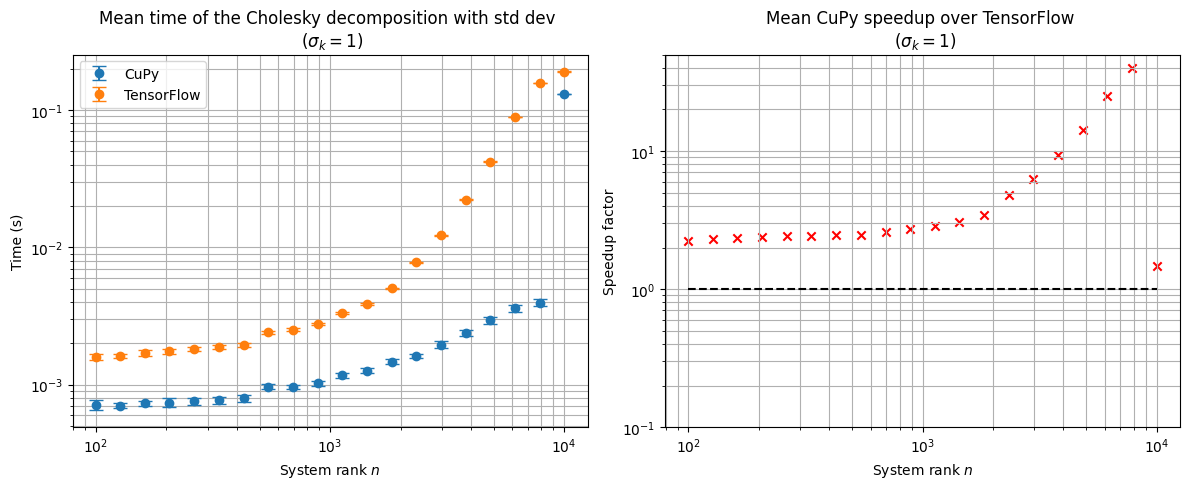

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.errorbar(ranks, np.mean(times_cp, axis=1), yerr=np.std(times_cp, axis=1), fmt='o', capsize=5, label="CuPy")
ax1.errorbar(ranks, np.mean(times_tf, axis=1), yerr=np.std(times_tf, axis=1), fmt='o', capsize=5, label="TensorFlow")
ax1.legend()
ax1.set_xlabel("System rank $n$")
ax1.set_ylabel("Time (s)")
ax1.set_title("Mean time of the Cholesky decomposition with std dev \n ($\sigma_k=1$)")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(which="both")

ax2.scatter(ranks,np.mean(times_tf,axis=1)/np.mean(times_cp,axis=1),marker="x",color="red")
ax2.set_xlabel("System rank $n$")
ax2.set_ylabel("Speedup factor")
ax2.set_title("Mean CuPy speedup over TensorFlow \n ($\sigma_k=1$)")
ax2.hlines(1,ranks[0],ranks[-1],linestyle="--",color="black")
ax2.set_ylim(0.1,50)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(which="both")

plt.tight_layout()
plt.show()

A fair, persistant speedup is visible across all tested system ranks. For some of them, standard deviation becomes noticable, but not enough to make it comparable to the TensorFlow speed.

In some runs (with the same seeding!) results were roughly the same for $n=100$. Those experiments also showed substantial standard deviations.

The graphs for all experiment runs show that the advantage CuPy had over TensorFlow melts away for $n=10000$. This was a consistent theme during the creation of the Jupyter notebook. This is interesting, but is not of any practical concern, as systems of that order are solved using conjugate gradient or other methods, rather than standard Cholesky decomposition.

We can conclude that the CuPy execution speed is superior to TensorFlows for the described problem in the relevant range of linear system orders. What also needs to be checked is the case when the kernel matrix starts to be ill-conditioned, which happenes as $\sigma^2_k \rightarrow \infty$, when $K \approx \mathbf{1}\mathbf{1}^T$, and therefore singular. We check this scenario for $\sigma_k=100$.

Computing for rank = 100
Computing for rank = 127
Computing for rank = 162
Computing for rank = 206
Computing for rank = 263
Computing for rank = 335
Computing for rank = 428
Computing for rank = 545
Computing for rank = 695
Computing for rank = 885
Computing for rank = 1128
Computing for rank = 1438
Computing for rank = 1832
Computing for rank = 2335
Computing for rank = 2976
Computing for rank = 3792
Computing for rank = 4832
Computing for rank = 6158
Computing for rank = 7847
Computing for rank = 10000


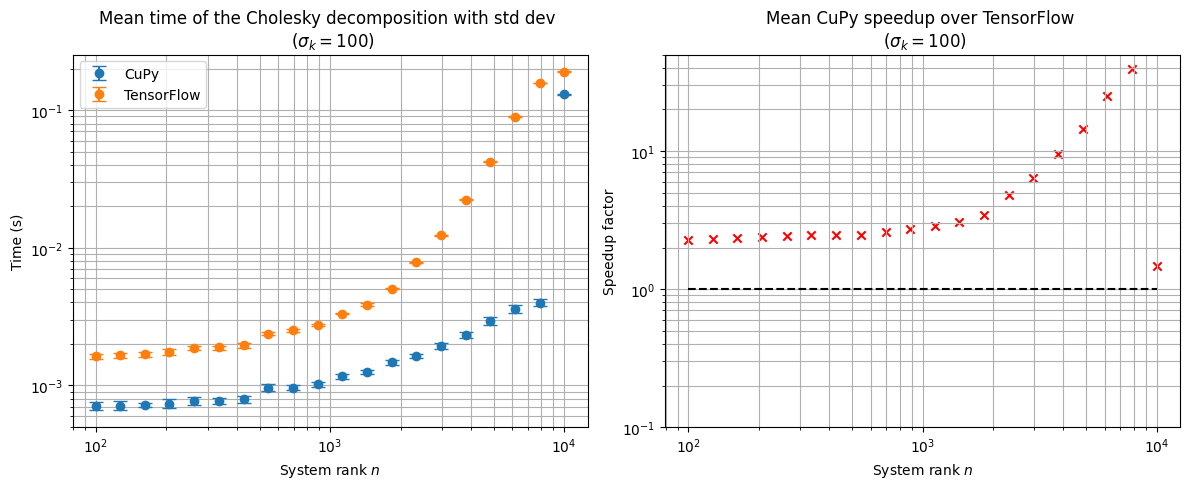

In [8]:
np.random.seed(42)

ranks=np.int32(np.logspace(2,4,20))
runs=1000
times_cp=np.zeros((len(ranks),runs))
times_tf=np.zeros((len(ranks),runs))

for rank_index in range(len(ranks)):

  print(f"Computing for rank = {ranks[rank_index]}")
  X=np.random.random((ranks[rank_index],ranks[rank_index]))
  Xcp=cp.asarray(X)
  Xtf = tf.constant(X)

  for run in range(runs):

    t0=time.time()
    Kcp=RBFcp(length_scale=100)(Xcp)
    L=cp.linalg.cholesky(Kcp)
    t1=time.time()
    times_cp[rank_index,run]=t1-t0

    t0=time.time()
    Ktf=RBFtf(length_scale=100)(Xtf)
    L=tf.linalg.cholesky(Ktf)
    t1=time.time()
    times_tf[rank_index,run]=t1-t0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.errorbar(ranks, np.mean(times_cp, axis=1), yerr=np.std(times_cp, axis=1), fmt='o', capsize=5, label="CuPy")
ax1.errorbar(ranks, np.mean(times_tf, axis=1), yerr=np.std(times_tf, axis=1), fmt='o', capsize=5, label="TensorFlow")
ax1.legend()
ax1.set_xlabel("System rank $n$")
ax1.set_ylabel("Time (s)")
ax1.set_title("Mean time of the Cholesky decomposition with std dev \n ($\sigma_k=100$)")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(which="both")

ax2.scatter(ranks,np.mean(times_tf,axis=1)/np.mean(times_cp,axis=1),marker="x",color="red")
ax2.set_xlabel("System rank $n$")
ax2.set_ylabel("Speedup factor")
ax2.set_title("Mean CuPy speedup over TensorFlow \n ($\sigma_k=100$)")
ax2.hlines(1,ranks[0],ranks[-1],linestyle="--",color="black")
ax2.set_ylim(0.1,50)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(which="both")

plt.tight_layout()
plt.show()

The curve has (almost) the exact shape. Maybe this was expected, but definitely worth to check out 😀.

##What now?
We showed that a novel machine learning framework can be outshined with CuPy when presented with a numerically complex task. Encouraged with the results, one might conclude that it could be useful for efficient implementation of kernel methods, and other ML models, for the GPUs. Sklearn, while still being a cornerstone traditional machine learning library for Python, still has a long way to go in its [GPU acceleration](https://www.geeksforgeeks.org/machine-learning/gpu-acceleration-in-scikit-learn/).


Gaussian processe regression could be an interesting case study. Implementing algorithms from advanced frameworks into CuPy, the GPU heir of the NumPy golden standard, could showcase a new way towards an efficient AI future. Old school, eficient numerical code may still have a place in the world of TensorFlow and PyTorch. If you found this as interesting as I did, stay tuned. More may be coming down the line 😎.

## References
1. <a name="ref1"></a> Jie Wang (2023). *An Intuitive Tutorial to Gaussian Process Regression*
2. <a name="ref2"></a> Chalupka et al (2012). *A Framework for Evaluating Approximation Methods for Gaussian Process Regression*.
3. <a name="ref3"></a> Matthews et al (2017). *GPflow: A Gaussian process library using TensorFlow*.
4. <a name="ref4"></a> Gardner et al (2018). *GPyTorch: Blackbox Matrix-Matrix Gaussian Process Inference with GPU Acceleration*.
5. <a name="ref5"></a> Okuta et al (2017). *CuPy: A NumPy-Compatible Library for NVIDIA GPU Calculations*.